In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [116]:
from tempfile import mkdtemp
from joblib import Memory, dump, load

In [4]:
import sqlite3
import json

In [118]:
with open('../config.json', 'r') as f:
    config = json.load(f)

In [119]:
for dictionary in config:
    dictionary.items()

dict_items([('threshold_nan', 0.4)])

dict_items([('database_path', '..\\database\\cms_data.db'), ('prvdr_category_file', '../provider_category.csv'), ('icd9_procedure_code_category_file', '../ICD 9 Procedural Code Mapping.csv'), ('hcpcs_code_category_file', '../hcpcs-code-categories.csv'), ('eda_report_location', '..\\output\\eda_report'), ('model_repository_location', '..\\models')])

dict_items([('ICD9_DIAGNOSIS_CODE_CATEGORY_URL', 'https://icd.codes/icd9cm'), ('HCPCS_CATEGORY_URL', 'https://www.hcpcsdata.com/Codes')])

dict_items([('HIGH_CARDINALITY_THRESHOLD', 4), ('INFREQUENT_CATEGORY_CUT_OFF', 200), ('DEFAULT_INFREQUENT_CATEGORY_CUT_OFF', 10), ('INFREQUENT_CATEGORY_LABEL', 'Infrequent'), ('DEFAULT_INFREQUENT_CATEGORY_LABEL', 'OTHERS'), ('RANDOM_STATE', 420), ('STATISTICAL_TEST_ALPHA', 0.05), ('TEST_SIZE_FOR_SPLIT', 0.2), ('MISSING_VALUE_LABEL', 'Missing')])

In [120]:
# constant variables
TEST_SIZE_FOR_SPLIT = config[3]['TEST_SIZE_FOR_SPLIT']
INFREQUENT_CATEGORY_CUT_OFF = config[3]["INFREQUENT_CATEGORY_CUT_OFF"]
INFREQUENT_CATEGORY_LABEL = config[3]["INFREQUENT_CATEGORY_LABEL"]
RANDOM_STATE = config[3]["RANDOM_STATE"]
MISSING_VALUE_LABEL = config[3]["MISSING_VALUE_LABEL"]
EDA_REPORT_LOCATION = config[1]["eda_report_location"]
MODEL_REPOSITORY_LOCATION = config[1]["model_repository_location"]

In [8]:
# import os

# cd_path = os.path.dirname(os.path.realpath(__file__))
# os.chdir(cd_path)

In [9]:
from StatisticalTest import ChiSquare
from CustomPipeline import CardinalityReducer, get_ct_feature_names, SelectColumnsTransfomer
from feature_importance import FeatureImportance

In [10]:
from imblearn import pipeline as imb_pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, f1_score, confusion_matrix, roc_auc_score

In [89]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV

In [13]:
from sklearn.decomposition import PCA, IncrementalPCA 
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler

In [14]:
conn_object = sqlite3.connect("../database/cms_data.db")

In [15]:
query_string = """SELECT inp.DESYNPUF_ID, inp.CLM_FROM_DT AS CLM_FROM_DT_INP, inp.CLM_THRU_DT AS CLM_THRU_DT_INP, inp.PRVDR_NUM AS PRVDR_NUM_INP, inp.CLM_PMT_AMT AS CLM_PMT_AMT_INP, inp.NCH_PRMRY_PYR_CLM_PD_AMT AS NCH_PRMRY_PYR_CLM_PD_AMT_INP, inp.AT_PHYSN_NPI AS AT_PHYSN_NPI_INP, inp.OP_PHYSN_NPI AS OP_PHYSN_NPI_INP, inp.CLM_ADMSN_DT AS CLM_ADMSN_DT_INP, inp.CLM_PASS_THRU_PER_DIEM_AMT AS CLM_PASS_THRU_PER_DIEM_AMT_INP, inp.NCH_BENE_IP_DDCTBL_AMT AS NCH_BENE_IP_DDCTBL_AMT_INP, inp.NCH_BENE_PTA_COINSRNC_LBLTY_AM AS NCH_BENE_PTA_COINSRNC_LBLTY_AM_INP, inp.NCH_BENE_BLOOD_DDCTBL_LBLTY_AM AS NCH_BENE_BLOOD_DDCTBL_LBLTY_AM_INP, inp.CLM_UTLZTN_DAY_CNT AS CLM_UTLZTN_DAY_CNT_INP, inp.NCH_BENE_DSCHRG_DT AS NCH_BENE_DSCHRG_DT_INP, inp.CLM_DRG_CD AS CLM_DRG_CD_INP, inp.PRVDR_NUM_CAT AS PRVDR_NUM_CAT_INP, inp.Next_CLM_ADMSN_DT AS Next_CLM_ADMSN_DT_INP, 
inp.Readmission_within_30days AS Readmission_within_30days_INP, inp.CLAIM_YEAR AS CLAIM_YEAR_INP, inp.ADMTNG_ICD9_DGNS_CD_CAT AS ADMTNG_ICD9_DGNS_CD_CAT_INP, inp.ICD9_DGNS_CD_1_CAT AS ICD9_DGNS_CD_1_CAT_INP, inp.ICD9_DGNS_CD_2_CAT AS ICD9_DGNS_CD_2_CAT_INP, inp.ICD9_DGNS_CD_3_CAT AS ICD9_DGNS_CD_3_CAT_INP, inp.ICD9_DGNS_CD_4_CAT AS ICD9_DGNS_CD_4_CAT_INP, 
inp.ICD9_DGNS_CD_5_CAT AS ICD9_DGNS_CD_5_CAT_INP, inp.ICD9_DGNS_CD_6_CAT AS ICD9_DGNS_CD_6_CAT_INP, inp.ICD9_DGNS_CD_7_CAT AS ICD9_DGNS_CD_7_CAT_INP, inp.ICD9_DGNS_CD_8_CAT AS ICD9_DGNS_CD_8_CAT_INP, inp.ICD9_DGNS_CD_9_CAT AS ICD9_DGNS_CD_9_CAT_INP, inp.ICD9_PRCDR_CD_1_CAT AS ICD9_PRCDR_CD_1_CAT_INP, 
out.CLM_FROM_DT as CLM_FROM_DT_OUT, out.CLM_THRU_DT as CLM_THRU_DT_OUT, out.PRVDR_NUM as PRVDR_NUM_OUT, out.CLM_PMT_AMT as CLM_PMT_AMT_OUT, 
out.NCH_PRMRY_PYR_CLM_PD_AMT as NCH_PRMRY_PYR_CLM_PD_AMT_OUT, out.AT_PHYSN_NPI as AT_PHYSN_NPI_OUT, out.NCH_BENE_BLOOD_DDCTBL_LBLTY_AM as NCH_BENE_BLOOD_DDCTBL_LBLTY_AM_OUT, 
out.ICD9_DGNS_CD_1 as ICD9_DGNS_CD_1_OUT, out.ICD9_DGNS_CD_2 as ICD9_DGNS_CD_2_OUT, out.NCH_BENE_PTB_DDCTBL_AMT as NCH_BENE_PTB_DDCTBL_AMT_OUT, 
out.NCH_BENE_PTB_COINSRNC_AMT as NCH_BENE_PTB_COINSRNC_AMT_OUT, out.HCPCS_CD_1 as HCPCS_CD_1_OUT, out.HCPCS_CD_2 as HCPCS_CD_2_OUT, out.HCPCS_CD_3 as HCPCS_CD_3_OUT, out.PRVDR_NUM_CAT as PRVDR_NUM_CAT_OUT, OUT.ICD9_DGNS_CD_1_CAT AS ICD9_DGNS_CD_1_CAT_OUT,OUT.ICD9_DGNS_CD_2_CAT AS ICD9_DGNS_CD_2_CAT_OUT,OUT.HCPCS_CD_1_CAT AS HCPCS_CD_1_CAT_OUT, OUT.HCPCS_CD_2_CAT AS HCPCS_CD_2_CAT_OUT,
OUT.HCPCS_CD_3_CAT AS HCPCS_CD_3_CAT_OUT, OUT.HCPCS_CD_1_CAT_DESC AS HCPCS_CD_1_CAT_DESC_OUT, OUT.HCPCS_CD_2_CAT_DESC AS HCPCS_CD_2_CAT_DESC_OUT, OUT.HCPCS_CD_3_CAT_DESC AS HCPCS_CD_3_CAT_DESC_OUT
FROM Inpatient_claims_2 inp LEFT JOIN Outpatient_claims_2 out 
on inp.DESYNPUF_ID = out.DESYNPUF_ID 
WHERE inp.NCH_BENE_DSCHRG_DT <= out.CLM_FROM_DT AND inp.Next_CLM_ADMSN_DT >= out.CLM_FROM_DT
"""



In [16]:
claim_data = pd.read_sql_query(
    query_string,
    con=conn_object,
    parse_dates={
        "CLM_FROM_DT_INP": {"format": "%Y-%m-%d"},
        "CLM_THRU_DT_INP": {"format": "%Y-%m-%d"},
        "CLM_ADMSN_DT_INP": {"format": "%Y-%m-%d"},
        "NCH_BENE_DSCHRG_DT_INP": {"format": "%Y-%m-%d"},
        "Next_CLM_ADMSN_DT_INP": {"format": "%Y-%m-%d"},
        "CLM_FROM_DT_OUT": {"format": "%Y-%m-%d"},
        "CLM_THRU_DT_OUT": {"format": "%Y-%m-%d"},
    },
)

In [17]:
claim_data.head()


DESYNPUF_ID CLM_FROM_DT_INP CLM_THRU_DT_INP PRVDR_NUM_INP  \
0  0008148FCB4CB644      2009-12-11      2009-12-23        1401RR   
1  002C70BCC706E14D      2008-03-25      2008-04-02        3600CS   
2  0116D4547592E193      2008-05-15      2008-05-18        4500DP   
3  0116D4547592E193      2008-05-30      2008-06-02        4500DP   
4  0157431266E82D4C      2009-06-21      2009-07-06        3600VA   

   CLM_PMT_AMT_INP  NCH_PRMRY_PYR_CLM_PD_AMT_INP  AT_PHYSN_NPI_INP  \
0          28000.0                           0.0      7.872370e+09   
1           6000.0                           0.0      5.333646e+09   
2           6000.0                           0.0      2.954834e+09   
3           4000.0                           0.0      3.368760e+09   
4          29000.0                           0.0      2.816497e+09   

   OP_PHYSN_NPI_INP CLM_ADMSN_DT_INP  CLM_PASS_THRU_PER_DIEM_AMT_INP  ...  \
0      5.118340e+09       2009-12-11                           400.0  ...   
1               NaN       2008-03-25                             0.0  ...   
2               NaN       2008-05-15                           100.0  ...   
3      9.909632e+09       2008-05-30                           300.0  ...   
4      2.861649e+09       2009-06-21                             0.0  ...   

   HCPCS_CD_3_OUT  PRVDR_NUM_CAT_OUT  ICD9_DGNS_CD_1_CAT_OUT  \
0           Q4081          1400-1499                 V01-V91   
1           97110          3500-3699                 460-519   
2            None          4500-4599                 320-389   
3            None          4500-4599                 710-739   
4            None          3500-3699                 580-629   

   ICD9_DGNS_CD_2_CAT_OUT HCPCS_CD_1_CAT_OUT HCPCS_CD_2_CAT_OUT  \
0                 580-629          'A' Codes        90935-90999   
1                 390-459        76506-76999               None   
2                    None        92002-92499               None   
3                    None        97110-97150               None   
4                    None          'A' Codes        85002-85999   

  HCPCS_CD_3_CAT_OUT                            HCPCS_CD_1_CAT_DESC_OUT  \
0          'Q' Codes  Transportation Services Including Ambulance, M...   
1        97110-97150                   Diagnostic Ultrasound Procedures   
2               None              Ophthalmology Services and Procedures   
3               None  Physical Medicine and Rehabilitation Therapeut...   
4               None  Transportation Services Including Ambulance, M...   

                 HCPCS_CD_2_CAT_DESC_OUT  \
0       Dialysis Services and Procedures   
1                                   None   
2                                   None   
3                                   None   
4  Hematology and Coagulation Procedures   

                             HCPCS_CD_3_CAT_DESC_OUT  
0           Miscellaneous Services (Temporary Codes)  
1  Physical Medicine and Rehabilitation Therapeut...  
2                                               None  
3                                               None  
4                                               None  

[5 rows x 54 columns]

In [18]:
claim_data.columns

Index(['DESYNPUF_ID', 'CLM_FROM_DT_INP', 'CLM_THRU_DT_INP', 'PRVDR_NUM_INP',
       'CLM_PMT_AMT_INP', 'NCH_PRMRY_PYR_CLM_PD_AMT_INP', 'AT_PHYSN_NPI_INP',
       'OP_PHYSN_NPI_INP', 'CLM_ADMSN_DT_INP',
       'CLM_PASS_THRU_PER_DIEM_AMT_INP', 'NCH_BENE_IP_DDCTBL_AMT_INP',
       'NCH_BENE_PTA_COINSRNC_LBLTY_AM_INP',
       'NCH_BENE_BLOOD_DDCTBL_LBLTY_AM_INP', 'CLM_UTLZTN_DAY_CNT_INP',
       'NCH_BENE_DSCHRG_DT_INP', 'CLM_DRG_CD_INP', 'PRVDR_NUM_CAT_INP',
       'Next_CLM_ADMSN_DT_INP', 'Readmission_within_30days_INP',
       'CLAIM_YEAR_INP', 'ADMTNG_ICD9_DGNS_CD_CAT_INP',
       'ICD9_DGNS_CD_1_CAT_INP', 'ICD9_DGNS_CD_2_CAT_INP',
       'ICD9_DGNS_CD_3_CAT_INP', 'ICD9_DGNS_CD_4_CAT_INP',
       'ICD9_DGNS_CD_5_CAT_INP', 'ICD9_DGNS_CD_6_CAT_INP',
       'ICD9_DGNS_CD_7_CAT_INP', 'ICD9_DGNS_CD_8_CAT_INP',
       'ICD9_DGNS_CD_9_CAT_INP', 'ICD9_PRCDR_CD_1_CAT_INP', 'CLM_FROM_DT_OUT',
       'CLM_THRU_DT_OUT', 'PRVDR_NUM_OUT', 'CLM_PMT_AMT_OUT',
       'NCH_PRMRY_PYR_CLM_PD_AMT_OUT', 'A

In [19]:
claim_data['Readmission_within_30days_INP'].value_counts()/claim_data.shape[0]

0    0.968536
1    0.031464
Name: Readmission_within_30days_INP, dtype: float64

In [20]:
# claim_data = claim_data[(claim_data['NCH_BENE_DSCHRG_DT_INP'] <= claim_data['CLM_FROM_DT_OUT']) & (claim_data['CLM_FROM_DT_OUT'] <= claim_data['Next_CLM_ADMSN_DT_INP'])]

In [21]:
claim_data.dtypes

DESYNPUF_ID                                   object
CLM_FROM_DT_INP                       datetime64[ns]
CLM_THRU_DT_INP                       datetime64[ns]
PRVDR_NUM_INP                                 object
CLM_PMT_AMT_INP                              float64
NCH_PRMRY_PYR_CLM_PD_AMT_INP                 float64
AT_PHYSN_NPI_INP                             float64
OP_PHYSN_NPI_INP                             float64
CLM_ADMSN_DT_INP                      datetime64[ns]
CLM_PASS_THRU_PER_DIEM_AMT_INP               float64
NCH_BENE_IP_DDCTBL_AMT_INP                   float64
NCH_BENE_PTA_COINSRNC_LBLTY_AM_INP           float64
NCH_BENE_BLOOD_DDCTBL_LBLTY_AM_INP           float64
CLM_UTLZTN_DAY_CNT_INP                       float64
NCH_BENE_DSCHRG_DT_INP                datetime64[ns]
CLM_DRG_CD_INP                                object
PRVDR_NUM_CAT_INP                             object
Next_CLM_ADMSN_DT_INP                 datetime64[ns]
Readmission_within_30days_INP                 

In [22]:
claim_data.shape

(38934, 54)

In [23]:
beneficiary_summary_2 = pd.read_sql_query(
    "select * from Beneficiary_Data_2",
    con=conn_object,
    parse_dates=["BENE_BIRTH_DT", "BENE_DEATH_DT"],
)

In [24]:
beneficiary_summary_2.shape


(343858, 33)

In [25]:
beneficiary_summary_2.dtypes


DESYNPUF_ID                         object
BENE_BIRTH_DT               datetime64[ns]
BENE_DEATH_DT               datetime64[ns]
BENE_SEX_IDENT_CD                    int64
BENE_RACE_CD                         int64
BENE_ESRD_IND                       object
BENE_HI_CVRAGE_TOT_MONS              int64
BENE_SMI_CVRAGE_TOT_MONS             int64
BENE_HMO_CVRAGE_TOT_MONS             int64
PLAN_CVRG_MOS_NUM                    int64
SP_ALZHDMTA                          int64
SP_CHF                               int64
SP_CHRNKIDN                          int64
SP_CNCR                              int64
SP_COPD                              int64
SP_DEPRESSN                          int64
SP_DIABETES                          int64
SP_ISCHMCHT                          int64
SP_OSTEOPRS                          int64
SP_RA_OA                             int64
SP_STRKETIA                          int64
MEDREIMB_IP                        float64
BENRES_IP                          float64
PPPYMT_IP  

In [26]:
final_df = pd.merge(
    left=beneficiary_summary_2,
    right=claim_data,
    left_on=["DESYNPUF_ID", "Year"],
    right_on=["DESYNPUF_ID", "CLAIM_YEAR_INP"],
    how="inner",
)


In [27]:
final_df.head()

DESYNPUF_ID BENE_BIRTH_DT BENE_DEATH_DT  BENE_SEX_IDENT_CD  \
0  0000525AB30E4DEF    1920-10-01           NaT                  2   
1  0008148FCB4CB644    1942-06-01           NaT                  1   
2  000C5BACF2F88B1E    1942-02-01           NaT                  2   
3  000C5BACF2F88B1E    1942-02-01           NaT                  2   
4  000C5BACF2F88B1E    1942-02-01           NaT                  2   

   BENE_RACE_CD BENE_ESRD_IND  BENE_HI_CVRAGE_TOT_MONS  \
0             1             0                       12   
1             3             Y                       12   
2             1             0                       12   
3             1             0                       12   
4             1             0                       12   

   BENE_SMI_CVRAGE_TOT_MONS  BENE_HMO_CVRAGE_TOT_MONS  PLAN_CVRG_MOS_NUM  ...  \
0                        12                         0                 12  ...   
1                        12                         0                 12  ...   
2                        12                        12                 12  ...   
3                        12                        12                 12  ...   
4                        12                        12                 12  ...   

   HCPCS_CD_3_OUT  PRVDR_NUM_CAT_OUT  ICD9_DGNS_CD_1_CAT_OUT  \
0            None          2000-2299                 V01-V91   
1           Q4081          1400-1499                 V01-V91   
2            None          4000-4499                 710-739   
3            None          4000-4499                 710-739   
4            None          4000-4499                 460-519   

   ICD9_DGNS_CD_2_CAT_OUT  HCPCS_CD_1_CAT_OUT  HCPCS_CD_2_CAT_OUT  \
0                    None         70010-76499         92502-92700   
1                 580-629           'A' Codes         90935-90999   
2                 390-459         70010-76499                None   
3                    None         70010-76499                None   
4                    None         70010-76499                None   

   HCPCS_CD_3_CAT_OUT                            HCPCS_CD_1_CAT_DESC_OUT  \
0                None  Diagnostic Radiology (Diagnostic Imaging) Proc...   
1           'Q' Codes  Transportation Services Including Ambulance, M...   
2                None  Diagnostic Radiology (Diagnostic Imaging) Proc...   
3                None  Diagnostic Radiology (Diagnostic Imaging) Proc...   
4                None  Diagnostic Radiology (Diagnostic Imaging) Proc...   

                             HCPCS_CD_2_CAT_DESC_OUT  \
0  Special Otorhinolaryngologic Services and Proc...   
1                   Dialysis Services and Procedures   
2                                               None   
3                                               None   
4                                               None   

                    HCPCS_CD_3_CAT_DESC_OUT  
0                                      None  
1  Miscellaneous Services (Temporary Codes)  
2                                      None  
3                                      None  
4                                      None  

[5 rows x 86 columns]

In [28]:
final_df['Readmission_within_30days_INP'].value_counts()/final_df.shape[0]

0    0.968505
1    0.031495
Name: Readmission_within_30days_INP, dtype: float64

In [29]:
categorical_features = [
    "BENE_SEX_IDENT_CD",
    "BENE_RACE_CD",
    "BENE_ESRD_IND",
    "SP_ALZHDMTA",
    "SP_CHF",
    "SP_CHRNKIDN",
    "SP_CNCR",
    "SP_COPD",
    "SP_DEPRESSN",
    "SP_DIABETES",
    "SP_ISCHMCHT",
    "SP_OSTEOPRS",
    "SP_RA_OA",
    "SP_STRKETIA",
    "BENE_STATE_COUNTY_CODE",
    "PRVDR_NUM_CAT_INP",
    "ADMTNG_ICD9_DGNS_CD_CAT_INP",
    "ICD9_DGNS_CD_1_CAT_INP",
    "ICD9_DGNS_CD_2_CAT_INP",
    "ICD9_DGNS_CD_3_CAT_INP",
    "ICD9_DGNS_CD_4_CAT_INP",
    "ICD9_DGNS_CD_5_CAT_INP",
    "ICD9_DGNS_CD_6_CAT_INP",
    "ICD9_DGNS_CD_7_CAT_INP",
    "ICD9_DGNS_CD_8_CAT_INP",
    "ICD9_DGNS_CD_9_CAT_INP",
    "ICD9_PRCDR_CD_1_CAT_INP",
    "PRVDR_NUM_CAT_OUT",
    "HCPCS_CD_1_CAT_OUT",
    "HCPCS_CD_2_CAT_OUT",
    "HCPCS_CD_3_CAT_OUT",
    "ICD9_DGNS_CD_1_CAT_OUT",
    "ICD9_DGNS_CD_2_CAT_OUT",
    "Readmission_within_30days_INP",
    # "BENE_AGE_CAT"
    # "AT_PHYSN_NPI_OUT",
    # "AT_PHYSN_NPI_INP",
    # "OP_PHYSN_NPI_INP"
]

In [30]:
# columns to drop:
# PRVDR_NUM_INP : Category column exist PRVDR_NUM_CAT_INP
# CLM_DRG_CD_INP : Claim Diagnosis Related Group Code not relevant for Readmission detection
# PRVDR_NUM_OUT : Category column exists PRVDR_NUM_CAT_OUT
# 'ICD9_DGNS_CD_1_OUT', 'ICD9_DGNS_CD_2_OUT', 'HCPCS_CD_1_OUT', 'HCPCS_CD_2_OUT', 'HCPCS_CD_3_OUT' : Category column exists
# 'HCPCS_CD_1_CAT_DESC_OUT', 'HCPCS_CD_2_CAT_DESC_OUT', 'HCPCS_CD_3_CAT_DESC_OUT' : Description column to be used later

cols_to_drop = [
    "Year",
    "CLAIM_YEAR_INP",
    "PRVDR_NUM_INP",
    "CLM_DRG_CD_INP",
    "PRVDR_NUM_OUT",
    "ICD9_DGNS_CD_1_OUT",
    "ICD9_DGNS_CD_2_OUT",
    "HCPCS_CD_1_OUT",
    "HCPCS_CD_2_OUT",
    "HCPCS_CD_3_OUT",
    "HCPCS_CD_1_CAT_DESC_OUT",
    "HCPCS_CD_2_CAT_DESC_OUT",
    "HCPCS_CD_3_CAT_DESC_OUT",
]
date_cols = list(final_df.select_dtypes(include="datetime").columns)
npi_cols = [col for col in final_df.select_dtypes(include="number") if "NPI" in col]

In [31]:
df = final_df.copy()


In [34]:
# df.to_sql("final_readmission_df", con=conn_object, index=False, if_exists="replace")

In [35]:
df[categorical_features] = df[categorical_features].astype("category")


In [36]:
df.drop(columns=cols_to_drop + date_cols + npi_cols, inplace=True, axis=1)

In [37]:
df.dtypes

DESYNPUF_ID                  object
BENE_SEX_IDENT_CD          category
BENE_RACE_CD               category
BENE_ESRD_IND              category
BENE_HI_CVRAGE_TOT_MONS       int64
                             ...   
ICD9_DGNS_CD_1_CAT_OUT     category
ICD9_DGNS_CD_2_CAT_OUT     category
HCPCS_CD_1_CAT_OUT         category
HCPCS_CD_2_CAT_OUT         category
HCPCS_CD_3_CAT_OUT         category
Length: 61, dtype: object

In [42]:
# from pandas_profiling import ProfileReport

# eda_report = ProfileReport(
#     df,
#     title="Exploratory Data Analysis",
#     minimal=True,
#     interactions={"continuous": False},
#     missing_diagrams={
#         "bar": True,
#         "matrix": True,
#         "heatmap": True,
#         "dendrogram": True,
#     },
#     correlations= {
#             "pearson": {"calculate": True},
#             "spearman": {"calculate": True},
#             "kendall": {"calculate": True},
#             "phi_k": {"calculate": True},
#             "cramers": {"calculate": True},
#         },
# )
# eda_report.to_file(f"{EDA_REPORT_LOCATION}\final_df_eda_report.html")

In [43]:
X = df.drop(columns=["Readmission_within_30days_INP"], axis=1)
y = df.loc[:, "Readmission_within_30days_INP"]

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE_FOR_SPLIT)

In [45]:
categorical_features = list(X.select_dtypes(include="category").columns)
numerical_features = list(X.select_dtypes(include="number").columns)

In [46]:
ct = ChiSquare(pd.concat([X_train, y_train], axis=1))


In [44]:
cramers = pd.DataFrame(
    {
        i: [ct.cramers_v(i, j) for j in categorical_features]
        for i in categorical_features
    }
)
cramers["column"] = [i for i in categorical_features if i not in ["memberid"]]
cramers.set_index("column", inplace=True)

<Figure size 1800x1800 with 0 Axes>

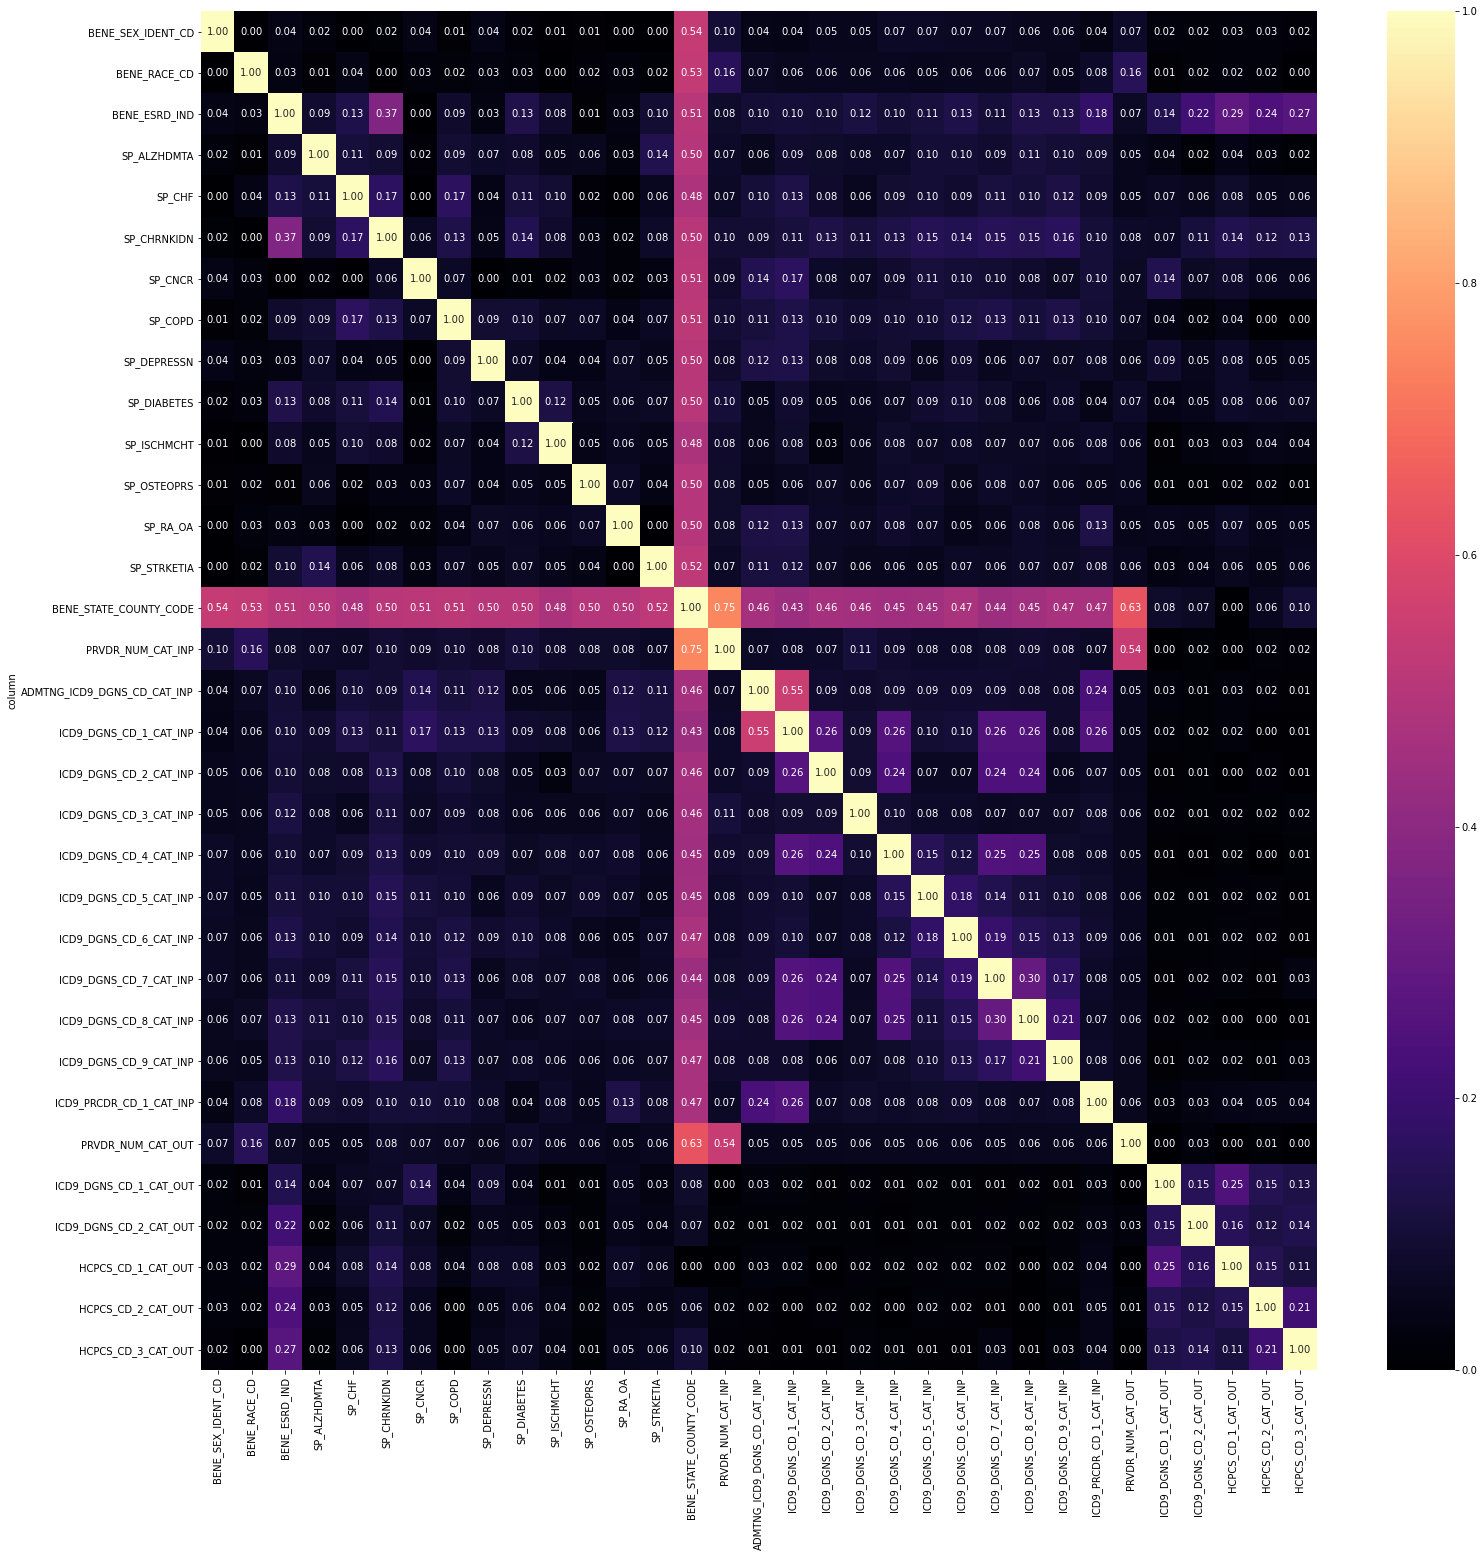

In [45]:
# categorical correlation heatmap
plt.figure(figsize=(25, 25))
sns.heatmap(cramers, annot=True, fmt=".2f", cmap="magma")
plt.show()

> High correlation between BENE_STATE_COUNTY_CODE & PRVDR_NUM_CAT_INP columns

In [46]:
# X_train.drop(columns=["BENE_STATE_COUNTY_CODE"], axis=1, inplace=True)
# X_test.drop(columns=["BENE_STATE_COUNTY_CODE"], axis=1, inplace=True)

<Figure size 1800x1800 with 0 Axes>

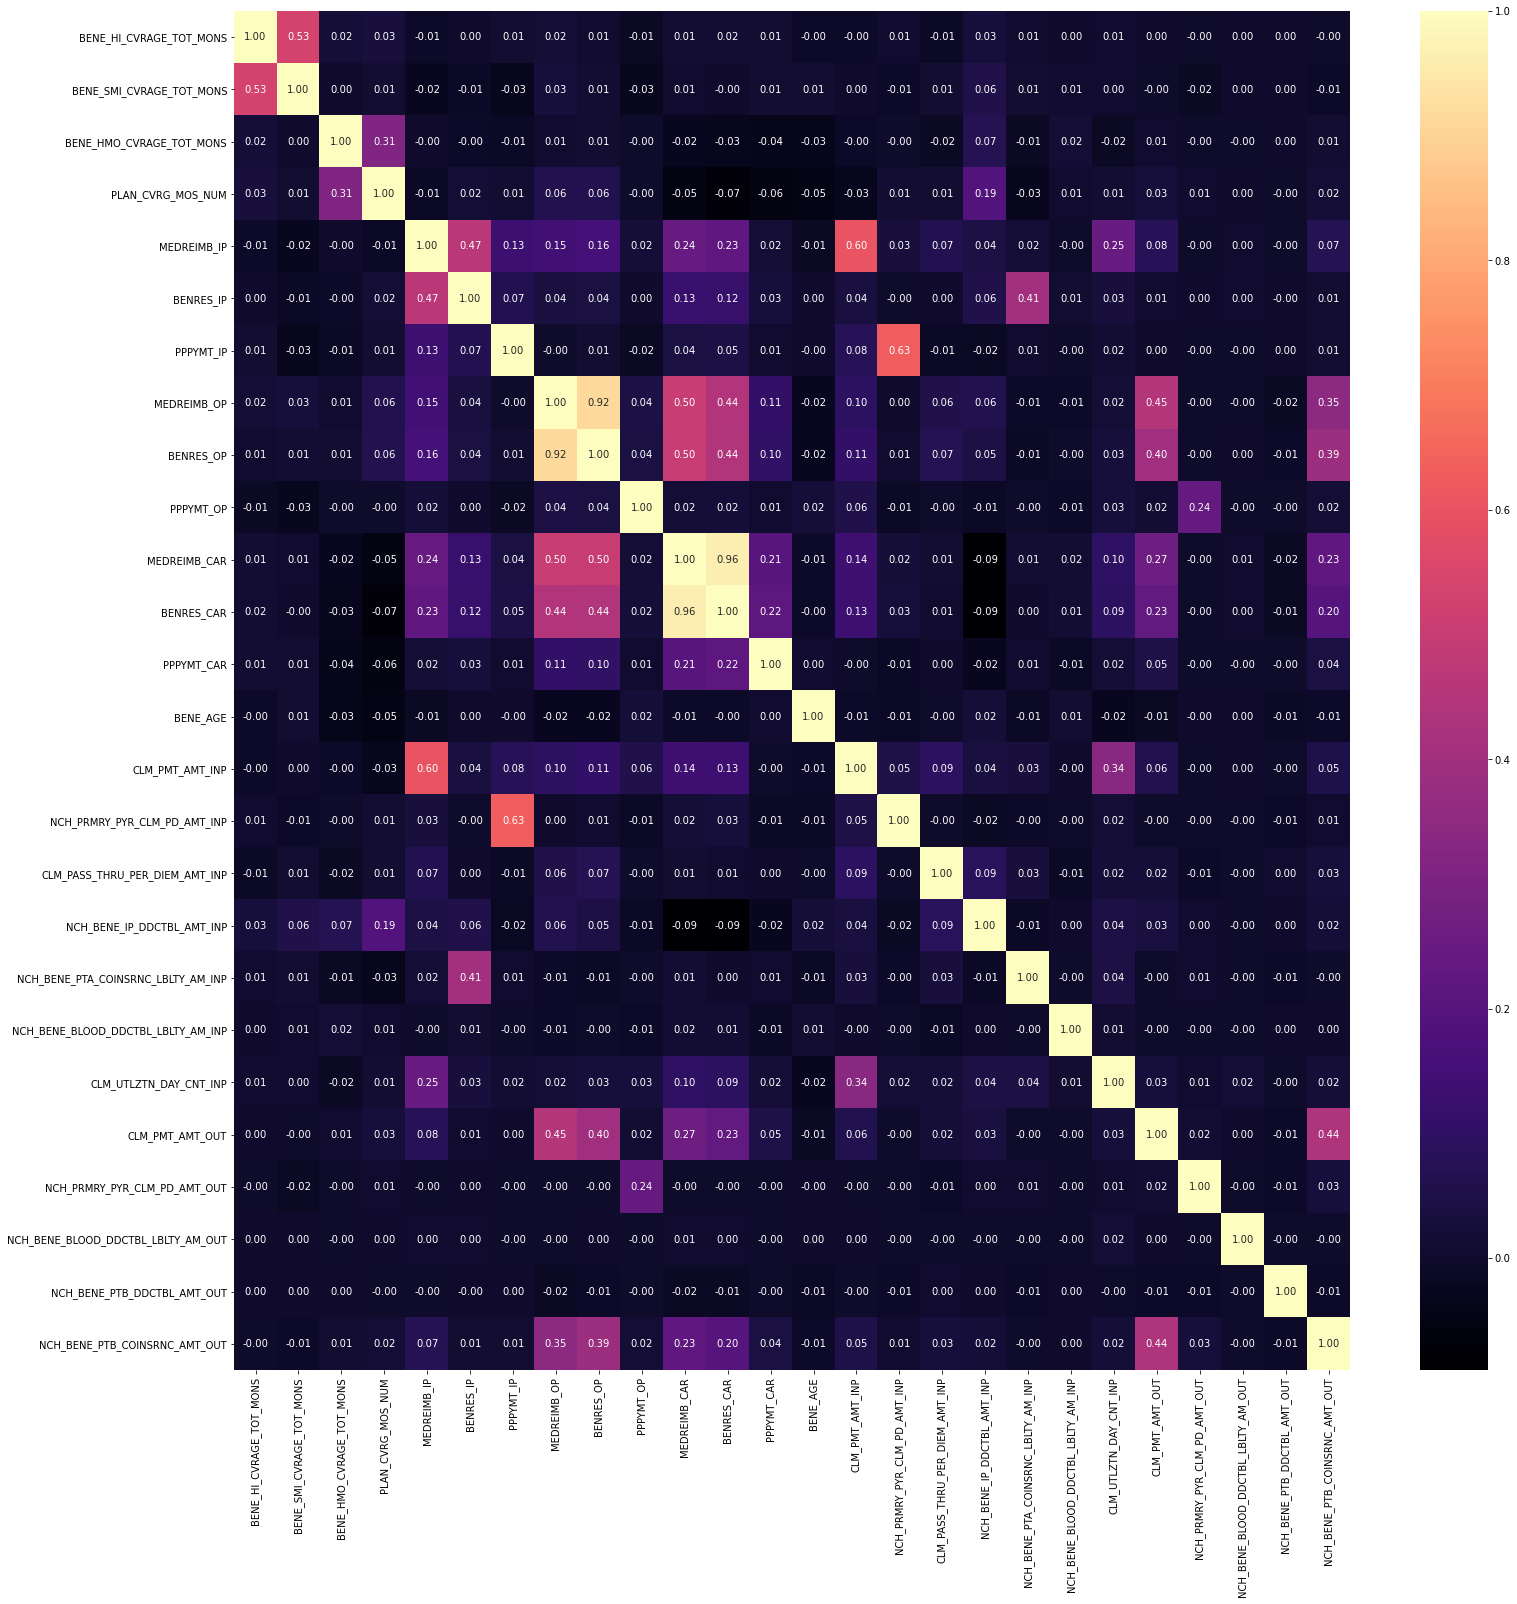

In [47]:
plt.figure(figsize=(25, 25))
sns.heatmap(
    X_train.select_dtypes(include="number").corr(), annot=True, fmt=".2f", cmap="magma"
)
# plt.show()
# #%%
# distribution_age = pd.crosstab(
#     pd.cut(df["BENE_AGE"], bins=5, labels=["25-40", "40-55", "55-70", "70-85", "85+"]),
#     df["Readmission_within_30days_INP"],
#     normalize="index",
# )



# #%%
# plt.figure(figsize=(10, 7))
# sns.barplot(distribution_age.index, distribution_age[1])
# sns.barplot(distribution_age.index, distribution_age[0])
# plt.xticks(rotation=90)

In [48]:
# #%%
# # Very high correlation between ('BENRES_OP', 'MEDREIMB_OP') & ('BENRES_CAR', 'MEDREIMB_CAR') hence dropping one column in the pair

X_train.drop(columns=["MEDREIMB_OP", "MEDREIMB_CAR"], inplace=True)
X_test.drop(columns=["MEDREIMB_OP", "MEDREIMB_CAR"], inplace=True)

c:\machinelearning\datascience\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [49]:
X_train.columns

Index(['DESYNPUF_ID', 'BENE_SEX_IDENT_CD', 'BENE_RACE_CD', 'BENE_ESRD_IND',
       'BENE_HI_CVRAGE_TOT_MONS', 'BENE_SMI_CVRAGE_TOT_MONS',
       'BENE_HMO_CVRAGE_TOT_MONS', 'PLAN_CVRG_MOS_NUM', 'SP_ALZHDMTA',
       'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD', 'SP_DEPRESSN',
       'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA',
       'MEDREIMB_IP', 'BENRES_IP', 'PPPYMT_IP', 'BENRES_OP', 'PPPYMT_OP',
       'BENRES_CAR', 'PPPYMT_CAR', 'BENE_AGE', 'BENE_STATE_COUNTY_CODE',
       'CLM_PMT_AMT_INP', 'NCH_PRMRY_PYR_CLM_PD_AMT_INP',
       'CLM_PASS_THRU_PER_DIEM_AMT_INP', 'NCH_BENE_IP_DDCTBL_AMT_INP',
       'NCH_BENE_PTA_COINSRNC_LBLTY_AM_INP',
       'NCH_BENE_BLOOD_DDCTBL_LBLTY_AM_INP', 'CLM_UTLZTN_DAY_CNT_INP',
       'PRVDR_NUM_CAT_INP', 'ADMTNG_ICD9_DGNS_CD_CAT_INP',
       'ICD9_DGNS_CD_1_CAT_INP', 'ICD9_DGNS_CD_2_CAT_INP',
       'ICD9_DGNS_CD_3_CAT_INP', 'ICD9_DGNS_CD_4_CAT_INP',
       'ICD9_DGNS_CD_5_CAT_INP', 'ICD9_DGNS_CD_6_CAT_INP',
       'ICD9_DG

In [50]:

for c in categorical_features:
    ct.TestIndependence(c, "Readmission_within_30days_INP")


BENE_SEX_IDENT_CD is NOT an important predictor. (Discard BENE_SEX_IDENT_CD from model)
BENE_RACE_CD is NOT an important predictor. (Discard BENE_RACE_CD from model)
BENE_ESRD_IND is IMPORTANT for Prediction
SP_ALZHDMTA is IMPORTANT for Prediction
SP_CHF is IMPORTANT for Prediction
SP_CHRNKIDN is IMPORTANT for Prediction
SP_CNCR is IMPORTANT for Prediction
SP_COPD is IMPORTANT for Prediction
SP_DEPRESSN is IMPORTANT for Prediction
SP_DIABETES is IMPORTANT for Prediction
SP_ISCHMCHT is IMPORTANT for Prediction
SP_OSTEOPRS is NOT an important predictor. (Discard SP_OSTEOPRS from model)
SP_RA_OA is IMPORTANT for Prediction
SP_STRKETIA is IMPORTANT for Prediction
BENE_STATE_COUNTY_CODE is IMPORTANT for Prediction
PRVDR_NUM_CAT_INP is IMPORTANT for Prediction
ADMTNG_ICD9_DGNS_CD_CAT_INP is IMPORTANT for Prediction
ICD9_DGNS_CD_1_CAT_INP is IMPORTANT for Prediction
ICD9_DGNS_CD_2_CAT_INP is NOT an important predictor. (Discard ICD9_DGNS_CD_2_CAT_INP from model)
ICD9_DGNS_CD_3_CAT_INP is NOT 

In [51]:
# X_train.drop(columns=ct.dfIrreleventCols, inplace=True)
# X_test.drop(columns=ct.dfIrreleventCols, inplace=True)

In [52]:
categorical_features = list(X_train.select_dtypes(include="category").columns)
numerical_feature = list(X_train.select_dtypes(include="number").columns)

In [53]:
X_train.columns
X_test.columns

Index(['DESYNPUF_ID', 'BENE_SEX_IDENT_CD', 'BENE_RACE_CD', 'BENE_ESRD_IND',
       'BENE_HI_CVRAGE_TOT_MONS', 'BENE_SMI_CVRAGE_TOT_MONS',
       'BENE_HMO_CVRAGE_TOT_MONS', 'PLAN_CVRG_MOS_NUM', 'SP_ALZHDMTA',
       'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD', 'SP_DEPRESSN',
       'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA',
       'MEDREIMB_IP', 'BENRES_IP', 'PPPYMT_IP', 'BENRES_OP', 'PPPYMT_OP',
       'BENRES_CAR', 'PPPYMT_CAR', 'BENE_AGE', 'BENE_STATE_COUNTY_CODE',
       'CLM_PMT_AMT_INP', 'NCH_PRMRY_PYR_CLM_PD_AMT_INP',
       'CLM_PASS_THRU_PER_DIEM_AMT_INP', 'NCH_BENE_IP_DDCTBL_AMT_INP',
       'NCH_BENE_PTA_COINSRNC_LBLTY_AM_INP',
       'NCH_BENE_BLOOD_DDCTBL_LBLTY_AM_INP', 'CLM_UTLZTN_DAY_CNT_INP',
       'PRVDR_NUM_CAT_INP', 'ADMTNG_ICD9_DGNS_CD_CAT_INP',
       'ICD9_DGNS_CD_1_CAT_INP', 'ICD9_DGNS_CD_2_CAT_INP',
       'ICD9_DGNS_CD_3_CAT_INP', 'ICD9_DGNS_CD_4_CAT_INP',
       'ICD9_DGNS_CD_5_CAT_INP', 'ICD9_DGNS_CD_6_CAT_INP',
       'ICD9_DG

Index(['DESYNPUF_ID', 'BENE_SEX_IDENT_CD', 'BENE_RACE_CD', 'BENE_ESRD_IND',
       'BENE_HI_CVRAGE_TOT_MONS', 'BENE_SMI_CVRAGE_TOT_MONS',
       'BENE_HMO_CVRAGE_TOT_MONS', 'PLAN_CVRG_MOS_NUM', 'SP_ALZHDMTA',
       'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD', 'SP_DEPRESSN',
       'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_RA_OA', 'SP_STRKETIA',
       'MEDREIMB_IP', 'BENRES_IP', 'PPPYMT_IP', 'BENRES_OP', 'PPPYMT_OP',
       'BENRES_CAR', 'PPPYMT_CAR', 'BENE_AGE', 'BENE_STATE_COUNTY_CODE',
       'CLM_PMT_AMT_INP', 'NCH_PRMRY_PYR_CLM_PD_AMT_INP',
       'CLM_PASS_THRU_PER_DIEM_AMT_INP', 'NCH_BENE_IP_DDCTBL_AMT_INP',
       'NCH_BENE_PTA_COINSRNC_LBLTY_AM_INP',
       'NCH_BENE_BLOOD_DDCTBL_LBLTY_AM_INP', 'CLM_UTLZTN_DAY_CNT_INP',
       'PRVDR_NUM_CAT_INP', 'ADMTNG_ICD9_DGNS_CD_CAT_INP',
       'ICD9_DGNS_CD_1_CAT_INP', 'ICD9_DGNS_CD_2_CAT_INP',
       'ICD9_DGNS_CD_3_CAT_INP', 'ICD9_DGNS_CD_4_CAT_INP',
       'ICD9_DGNS_CD_5_CAT_INP', 'ICD9_DGNS_CD_6_CAT_INP',
       'ICD9_DG

In [54]:
# Imputation objects
std_scalar = StandardScaler()
min_max_scalar = MinMaxScaler()
onehot_encoder = OneHotEncoder(drop="first", sparse=False)
median_imputer = SimpleImputer(strategy="median", missing_values=np.nan)
constant_imputer = SimpleImputer(
    strategy="constant", fill_value=MISSING_VALUE_LABEL, missing_values=np.nan
)

In [55]:
numerical_cachedir = mkdtemp()
numerical_memory = Memory(location=numerical_cachedir, verbose=10)
catergorical_cachedir = mkdtemp()
categorical_memory = Memory(location=numerical_cachedir, verbose=10)

In [56]:
numerical_transformer = Pipeline(
    steps=[("imputer_with_medium", median_imputer), ("scaler", std_scalar)],
    verbose=True,
    memory=numerical_memory
)


In [57]:
categorical_transformer = Pipeline(
    steps=[
        ("imputer_with_constant", constant_imputer),
        (
            "infrequent_category_remover",
            CardinalityReducer(cutt_off=INFREQUENT_CATEGORY_CUT_OFF, label=INFREQUENT_CATEGORY_LABEL),
        ),
        ("onehot", onehot_encoder),
    ],
    verbose=True,
    memory=categorical_memory
)

In [58]:
preprocessing_pipeline = ColumnTransformer(
    [
        ("categorical", categorical_transformer, categorical_features),
        ("numerical", numerical_transformer, numerical_feature),
    ],
    remainder="drop",
    verbose=True,
)


In [59]:
X_train_transformed = preprocessing_pipeline.fit_transform(X_train)
X_test_transformed = preprocessing_pipeline.transform(X_test)

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SimpleImputer(fill_value='Missing', strategy='constant'),       BENE_SEX_IDENT_CD BENE_RACE_CD BENE_ESRD_IND SP_ALZHDMTA SP_CHF  \
28378                 2            5             0           2      1   
26645                 2            1             0           2      1   
3027                  1            1             0           2      1   
13952                 2            2             Y           2      1   
3087                  2            2             0           1      1   
...                 ...          ...           ...         ...    ...   
33782                 2            1             0           1      2   
26620                 2            5             0           2      2   
14705                 1            1       ..., 
None, None, message_clsname='Pipeline', message='(step 1 of 3) Processing impute

c:\machinelearning\datascience\lib\site-packages\sklearn\pipeline.py:296: UserWarning: Persisting input arguments took 2.25s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 3.8s, 0.1min
[Pipeline] ............ (step 3 of 3) Processing onehot, total=   0.2s
[ColumnTransformer] ... (1 of 2) Processing categorical, total=   9.1s
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SimpleImputer(strategy='median'),        BENE_HI_CVRAGE_TOT_MONS  BENE_SMI_CVRAGE_TOT_MONS  \
28378                       12                        12   
26645                       12                        12   
3027                        12                        12   
13952                       12                        12   
3087                        12                        12   
...                        ...                       ...   
33782                       12                        12   
26620                       12                        12   
14705                       12                 

In [60]:
X_train_transformed = pd.DataFrame(
    X_train_transformed, columns=get_ct_feature_names(preprocessing_pipeline)
)
X_test_transformed = pd.DataFrame(
    X_test_transformed, columns=get_ct_feature_names(preprocessing_pipeline)
)

In [61]:
X_train_transformed

BENE_SEX_IDENT_CD_2  BENE_RACE_CD_2  BENE_RACE_CD_3  BENE_RACE_CD_5  \
0                      1.0             0.0             0.0             1.0   
1                      1.0             0.0             0.0             0.0   
2                      0.0             0.0             0.0             0.0   
3                      1.0             1.0             0.0             0.0   
4                      1.0             1.0             0.0             0.0   
...                    ...             ...             ...             ...   
30958                  1.0             0.0             0.0             0.0   
30959                  1.0             0.0             0.0             1.0   
30960                  0.0             0.0             0.0             0.0   
30961                  1.0             0.0             0.0             0.0   
30962                  1.0             0.0             0.0             0.0   

       BENE_ESRD_IND_Y  SP_ALZHDMTA_2  SP_CHF_2  SP_CHRNKIDN_2  SP_CNCR_2  \
0                  0.0            1.0       0.0            0.0        1.0   
1                  0.0            1.0       0.0            0.0        0.0   
2                  0.0            1.0       0.0            0.0        1.0   
3                  1.0            1.0       0.0            0.0        1.0   
4                  0.0            0.0       0.0            0.0        1.0   
...                ...            ...       ...            ...        ...   
30958              0.0            0.0       1.0            0.0        1.0   
30959              0.0            1.0       1.0            1.0        0.0   
30960              0.0            0.0       0.0            0.0        1.0   
30961              0.0            1.0       0.0            0.0        1.0   
30962              0.0            0.0       0.0            1.0        1.0   

       SP_COPD_2  ...  CLM_PASS_THRU_PER_DIEM_AMT_INP  \
0            0.0  ...                        0.269908   
1            0.0  ...                       -0.321834   
2            0.0  ...                        0.713715   
3            0.0  ...                       -0.321834   
4            1.0  ...                       -0.321834   
...          ...  ...                             ...   
30958        0.0  ...                       -0.321834   
30959        1.0  ...                       -0.321834   
30960        0.0  ...                        2.636876   
30961        1.0  ...                       -0.321834   
30962        0.0  ...                        0.269908   

       NCH_BENE_IP_DDCTBL_AMT_INP  NCH_BENE_PTA_COINSRNC_LBLTY_AM_INP  \
0                       -0.633139                            -0.08552   
1                       -0.633139                            -0.08552   
2                        1.416093                            -0.08552   
3                        1.416093                            -0.08552   
4                       -0.633139                            -0.08552   
...                           ...                                 ...   
30958                   -0.633139                            -0.08552   
30959                    1.416093                            -0.08552   
30960                    1.416093                            -0.08552   
30961                    1.416093                            -0.08552   
30962                   -0.633139                            -0.08552   

       NCH_BENE_BLOOD_DDCTBL_LBLTY_AM_INP  CLM_UTLZTN_DAY_CNT_INP  \
0                               -0.042181               -0.605258   
1                               -0.042181               -0.026600   
2                               -0.042181                1.323601   
3                               -0.042181               -0.605258   
4                               -0.042181               -0.412372   
...                                   ...                     ...   
30958                           -0.042181               -0.412372   
30959                          

In [62]:
y_train = y_train.reset_index().drop(columns='index', axis=1).values.ravel()
y_test = y_test.reset_index().drop(columns='index', axis=1).values.ravel()

In [63]:
y_train
y_test

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [128]:
lr = LogisticRegression(random_state=RANDOM_STATE)
lda = LinearDiscriminantAnalysis()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight="balanced")
gnb = GaussianNB()
rfc = RandomForestClassifier(class_weight="balanced", random_state=RANDOM_STATE)

In [129]:
num_folds = 5
seed = 7
scoring = "f1"
models = []
models.append(("LR", lr))
models.append(("LDA", lda))
models.append(("KNN", knn))
models.append(("CART", dt))
models.append(("NB", gnb))

In [130]:
smt = SMOTE(random_state=RANDOM_STATE, n_jobs=-1)
random_oversampling = RandomOverSampler(random_state=RANDOM_STATE)

In [131]:
dt_pipeline = Pipeline([
    #("Select Relevent Columns", SelectColumnsTransfomer(columns=numerical_feature + ct.dfReleventCols)),
    ("Preprocessing Step", preprocessing_pipeline),
    ("DT_Classifier", dt)
    ])

In [132]:
dt_smote_pipeline = imb_pipeline.Pipeline([("Preprocessing Step", preprocessing_pipeline), 
                                      ("SMOTE Sampling", smt), 
                                      ("Classifier", DecisionTreeClassifier(random_state=RANDOM_STATE))])

dt_randover_pipeline = imb_pipeline.Pipeline([("Preprocessing Step", preprocessing_pipeline), 
                                      ("Random OverSampling", random_oversampling), 
                                      ("Classifier", DecisionTreeClassifier(random_state=RANDOM_STATE))])

In [133]:
def getMetricsData(y_true, y_pred):
    print(f'Accuracy score is {accuracy_score(y_true, y_pred)}')
    print(f'Precision score is {precision_score(y_true, y_pred)}')
    print(f'Recall score is {recall_score(y_true, y_pred)}')
    print(f'F1 score is {f1_score(y_true, y_pred)}')
    print(f'AUC ROC score is {roc_auc_score(y_true, y_pred)}')
    print(f'Classification Report is \n {classification_report(y_true, y_pred)}')
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap="Blues", fmt="d")
    plt.show()

In [134]:
def fit_predict(pipeline):
    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'{"="*40} {pipeline.steps[-1][-1]} {"="*50}')
    getMetricsData(y_test, y_pred)

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\SAURAB~1\AppData\Local\Temp\tmpgua40cpv\joblib\sklearn\pipeline\_fit_transform_one\ec5f549ddc7e27536f2bb6039ad1c086
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]2.3s, 0.0min    : Loading _fit_transform_one from C:\Users\SAURAB~1\AppData\Local\Temp\tmpgua40cpv\joblib\sklearn\pipeline\_fit_transform_one\558094b203edc859372cdc80f1cf6b28
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Pipeline] ............ (step 3 of 3) Processing onehot, total=   0.2s
[ColumnTransformer] ... (1 of 2) Processing categorical, total=   2.7s
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\SAURAB~1\AppData\Local\Temp\tmpgua40cpv\joblib\sklearn\pipeline\_fit_transform_one\2e3945fe6af12b1bb09a540f18063036
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Pipeline] ............ (step 2 of 2) Processing scaler, total=   

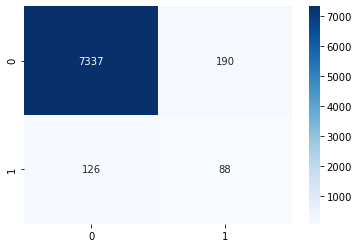

In [135]:
fit_predict(dt_pipeline)

In [137]:
# dump(dt_pipeline, f'{MODEL_REPOSITORY_LOCATION}\decisionTreePipeline.pkl', compress=1)
# dump(dt_pipeline[-1], f'{MODEL_REPOSITORY_LOCATION}\decisionTreeClassifier.pkl', compress=1)

In [72]:
feature_importance = FeatureImportance(dt_pipeline)
feature_importance.plot(top_n_features=50, width=1000)

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\SAURAB~1\AppData\Local\Temp\tmpgua40cpv\joblib\sklearn\pipeline\_fit_transform_one\ec5f549ddc7e27536f2bb6039ad1c086
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]2.6s, 0.0min    : Loading _fit_transform_one from C:\Users\SAURAB~1\AppData\Local\Temp\tmpgua40cpv\joblib\sklearn\pipeline\_fit_transform_one\558094b203edc859372cdc80f1cf6b28
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Pipeline] ............ (step 3 of 3) Processing onehot, total=   0.2s
[ColumnTransformer] ... (1 of 2) Processing categorical, total=   2.9s
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\SAURAB~1\AppData\Local\Temp\tmpgua40cpv\joblib\sklearn\pipeline\_fit_transform_one\2e3945fe6af12b1bb09a540f18063036
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Pipeline] ............ (step 2 of 2) Processing scaler, total=   

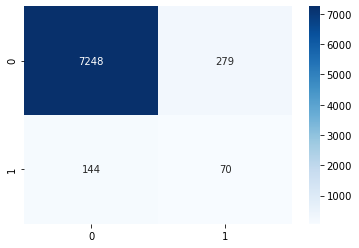

In [73]:
fit_predict(dt_smote_pipeline)

In [74]:
feature_importance = FeatureImportance(dt_smote_pipeline)
feature_importance.plot(top_n_features=50, width=1000)

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\SAURAB~1\AppData\Local\Temp\tmpgua40cpv\joblib\sklearn\pipeline\_fit_transform_one\ec5f549ddc7e27536f2bb6039ad1c086
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]2.3s, 0.0min    : Loading _fit_transform_one from C:\Users\SAURAB~1\AppData\Local\Temp\tmpgua40cpv\joblib\sklearn\pipeline\_fit_transform_one\558094b203edc859372cdc80f1cf6b28
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Pipeline] ............ (step 3 of 3) Processing onehot, total=   0.2s
[ColumnTransformer] ... (1 of 2) Processing categorical, total=   2.6s
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\SAURAB~1\AppData\Local\Temp\tmpgua40cpv\joblib\sklearn\pipeline\_fit_transform_one\2e3945fe6af12b1bb09a540f18063036
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Pipeline] ............ (step 2 of 2) Processing scaler, total=   

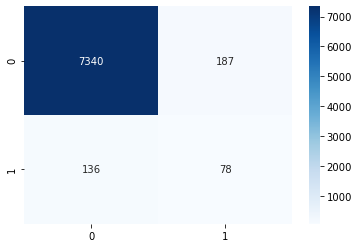

In [75]:
fit_predict(dt_randover_pipeline)

In [76]:
feature_importance = FeatureImportance(dt_randover_pipeline)
feature_importance.plot(top_n_features=50, width=1000)

In [77]:
pca = PCA(n_components=0.95)
ipca = IncrementalPCA(n_components=0.95)

In [78]:
parameter_grid = {'DT_Classifier__max_depth': np.linspace(1, 32, 32, endpoint=True), 
                  'DT_Classifier__min_samples_leaf': np.linspace(0.1, 0.5, 5, endpoint=True), 
                  "DT_Classifier__min_samples_split" : np.linspace(0.1, 1.0, 10, endpoint=True),
                 "DT_Classifier__max_features" : ['auto', 'log2', None]}

In [79]:
rand_grid_search = RandomizedSearchCV(estimator=dt_pipeline, param_distributions=parameter_grid, n_iter=15, scoring="f1", verbose=4)

In [80]:
num_folds = 5
seed = 7
scoring = "f1"
models = []
models.append(("LR", lr))
models.append(("LDA", lda))
models.append(("KNN", knn))
models.append(("CART", dt))
models.append(("NB", gnb))

In [81]:
# results = []
# names = []
# for name, model in models:
#     kfold = KFold(n_splits=num_folds, random_state=seed)
#     pipeline = Pipeline([("Preprocessing Step", preprocessing_pipeline), ("DT Classifier", model)])
#     cv_results = cross_val_score(
#         pipeline, X_train, y_train, cv=kfold, scoring=scoring
#     )
#     results.append(cv_results)
#     names.append(name)
#     msg = "%s %f %f " % (name, cv_results.mean(), cv_results.std())
#     print(msg)


# Ensembling Classifiers

In [92]:
from hpsklearn import HyperoptEstimator, extra_trees, random_forest, decision_tree
from hyperopt import hp, fmin, tpe, rand, pyll, STATUS_OK, STATUS_FAIL, Trials, space_eval

In [83]:
estim_extratrees = HyperoptEstimator(classifier=extra_trees('extratrees_clf'), preprocessing=[], 
                          algo=tpe.suggest, max_evals=10, 
                          trial_timeout=300)

estim_extratrees.fit(X_train_transformed.to_numpy(), y_train)

estim_extratrees.score(X_test_transformed.to_numpy(), y_test) 

estim_extratrees.best_model()['learner']

extratrees_clf = estim_extratrees.best_model()['learner']

100%|██████████████████████████████████████████████| 10/10 [00:09<00:00, 10.00s/trial, best loss: 0.020345551429032827]


0.9794600180855186

ExtraTreesClassifier(max_features=0.7363742386320187, n_estimators=80, n_jobs=1,
                     random_state=4, verbose=False)

In [80]:
extratrees_clf = ExtraTreesClassifier(max_features=0.7363742386320187, n_estimators=80, n_jobs=-1,
                     random_state=4, verbose=False)

In [81]:
extratrees_clf_pipeline = Pipeline([
    ("Preprocessing Step", preprocessing_pipeline),
    ("Extratrees_Classifier", extratrees_clf)
    ])

[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\SAURAB~1\AppData\Local\Temp\tmpgua40cpv\joblib\sklearn\pipeline\_fit_transform_one\ec5f549ddc7e27536f2bb6039ad1c086
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]2.8s, 0.0min    : Loading _fit_transform_one from C:\Users\SAURAB~1\AppData\Local\Temp\tmpgua40cpv\joblib\sklearn\pipeline\_fit_transform_one\558094b203edc859372cdc80f1cf6b28
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Pipeline] ............ (step 3 of 3) Processing onehot, total=   0.2s
[ColumnTransformer] ... (1 of 2) Processing categorical, total=   3.1s
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\SAURAB~1\AppData\Local\Temp\tmpgua40cpv\joblib\sklearn\pipeline\_fit_transform_one\2e3945fe6af12b1bb09a540f18063036
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Pipeline] ............ (step 2 of 2) Processing scaler, total=   

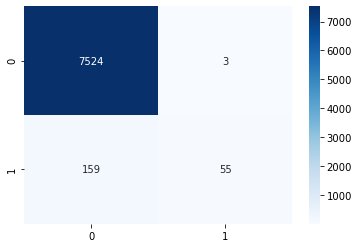

In [82]:
fit_predict(extratrees_clf_pipeline)

In [85]:
estim_rfc = HyperoptEstimator(classifier=random_forest('rfc_clf'), preprocessing=[], 
                          algo=tpe.suggest, max_evals=10, 
                          trial_timeout=300)

estim_rfc.fit(X_train_transformed.to_numpy(), y_train)

estim_rfc.score(X_test_transformed.to_numpy(), y_test) 

estim_rfc.best_model()['learner']

rfc_clf = estim_rfc.best_model()['learner']

100%|██████████████████████████████████████████████| 10/10 [00:48<00:00, 49.00s/trial, best loss: 0.020668496689811078]


0.9813977522283943

RandomForestClassifier(bootstrap=False, max_features=0.40810278517436016,
                       n_estimators=73, n_jobs=1, random_state=1,
                       verbose=False)

In [83]:
rfc_model_1 = RandomForestClassifier(bootstrap=False, max_features=0.40810278517436016,
                       n_estimators=73, n_jobs=-1, random_state=1,
                       verbose=False)

In [86]:
rfc_clf_pipeline = Pipeline([
    ("Preprocessing Step", preprocessing_pipeline),
    ("Extratrees_Classifier", rfc_model_1)
    ])

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\SAURAB~1\AppData\Local\Temp\tmpgua40cpv\joblib\sklearn\pipeline\_fit_transform_one\ec5f549ddc7e27536f2bb6039ad1c086
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]2.4s, 0.0min    : Loading _fit_transform_one from C:\Users\SAURAB~1\AppData\Local\Temp\tmpgua40cpv\joblib\sklearn\pipeline\_fit_transform_one\558094b203edc859372cdc80f1cf6b28
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Pipeline] ............ (step 3 of 3) Processing onehot, total=   0.3s
[ColumnTransformer] ... (1 of 2) Processing categorical, total=   2.8s
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\SAURAB~1\AppData\Local\Temp\tmpgua40cpv\joblib\sklearn\pipeline\_fit_transform_one\2e3945fe6af12b1bb09a540f18063036
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Pipeline] ............ (step 2 of 2) Processing scaler, total=   

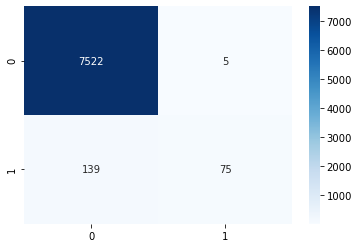

In [87]:
fit_predict(rfc_clf_pipeline)

In [123]:
# dump(rfc_model_1, f'{MODEL_REPOSITORY_LOCATION}\RandomForestEstimator.joblib')

# dump(rfc_clf_pipeline, f'{MODEL_REPOSITORY_LOCATION}\RandomForestPipeline.joblib', compress=1)

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\SAURAB~1\AppData\Local\Temp\tmpgua40cpv\joblib\sklearn\pipeline\_fit_transform_one\ec5f549ddc7e27536f2bb6039ad1c086
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]2.3s, 0.0min    : Loading _fit_transform_one from C:\Users\SAURAB~1\AppData\Local\Temp\tmpgua40cpv\joblib\sklearn\pipeline\_fit_transform_one\558094b203edc859372cdc80f1cf6b28
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Pipeline] ............ (step 3 of 3) Processing onehot, total=   0.2s
[ColumnTransformer] ... (1 of 2) Processing categorical, total=   2.6s
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\SAURAB~1\AppData\Local\Temp\tmpgua40cpv\joblib\sklearn\pipeline\_fit_transform_one\2e3945fe6af12b1bb09a540f18063036
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Pipeline] ............ (step 2 of 2) Processing scaler, total=   

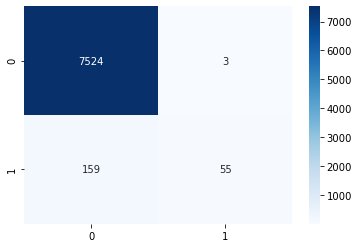

In [88]:
fit_predict(extratrees_clf_pipeline)

In [130]:
X_train_transformed_sampled, y_train_sampled = smt.fit_sample(X_train_transformed, y_train)

In [131]:
estim_rfc = HyperoptEstimator(classifier=random_forest('rfc_clf'), preprocessing=[], 
                          algo=tpe.suggest, max_evals=20, 
                          trial_timeout=300)

estim_rfc.fit(X_train_transformed_sampled.to_numpy(), y_train_sampled)

estim_rfc.score(X_test_transformed.to_numpy(), y_test) 

estim_rfc.best_model()['learner']

rfc_clf = estim_rfc.best_model()['learner']

100%|██████████████████████████████████████████████████████████████| 20/20 [03:19<00:00, 199.39s/trial, best loss: 0.0]


0.9715798992378246

RandomForestClassifier(bootstrap=False, criterion='entropy',
                       max_features='sqrt', n_estimators=73, n_jobs=1,
                       random_state=4, verbose=False)

In [106]:
estimators = [
             ("dt_pipeline", dt_pipeline), 
             ("rfc_pipeline", rfc_clf_pipeline),
             ("extratrees_pipeline", extratrees_clf_pipeline)
             ]

In [112]:
voting_clf = VotingClassifier(estimators=estimators, voting='soft', verbose=True, n_jobs=-1)

In [108]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('dt_pipeline',
                              Pipeline(steps=[('Preprocessing Step',
                                               ColumnTransformer(transformers=[('categorical',
                                                                                Pipeline(memory=Memory(location=C:\Users\SAURAB~1\AppData\Local\Temp\tmpgua40cpv\joblib),
                                                                                         steps=[('imputer_with_constant',
                                                                                                 SimpleImputer(fill_value='Missing',
                                                                                                               strategy='constant')),
                                                                                                ('infrequent_category_remover',
                                                                                                 Cardina

In [109]:
y_pred = voting_clf.predict(X_test)

Accuracy score is 0.9802351117426689
Precision score is 0.8505747126436781
Recall score is 0.34579439252336447
F1 score is 0.4916943521594684
AUC ROC score is 0.6720336384033058
Classification Report is 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      7527
           1       0.85      0.35      0.49       214

    accuracy                           0.98      7741
   macro avg       0.92      0.67      0.74      7741
weighted avg       0.98      0.98      0.98      7741



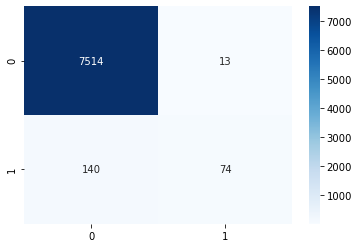

In [110]:
getMetricsData(y_true=y_test, y_pred=y_pred)

In [126]:
# dump(voting_clf, f'{MODEL_REPOSITORY_LOCATION}\VotingClassifier.pkl', compress=1)

In [150]:
bagg_clf = BaggingClassifier(base_estimator=rfc_model_1, n_estimators=10, random_state=RANDOM_STATE, 
                             max_samples=0.8, max_features=0.8, bootstrap_features=False, bootstrap=True)

In [151]:
bagg_clf.fit(X_train_transformed, y_train)

BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=False,
                                                        max_features=0.40810278517436016,
                                                        n_estimators=73,
                                                        n_jobs=-1,
                                                        random_state=1,
                                                        verbose=False),
                  max_features=0.8, max_samples=0.8, random_state=420)

In [152]:
y_pred = bagg_clf.predict(X_test_transformed)

Accuracy score is 0.9766180080093011
Precision score is 0.9714285714285714
Recall score is 0.1588785046728972
F1 score is 0.27309236947791166
AUC ROC score is 0.5793728248088812
Classification Report is 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      7527
           1       0.97      0.16      0.27       214

    accuracy                           0.98      7741
   macro avg       0.97      0.58      0.63      7741
weighted avg       0.98      0.98      0.97      7741



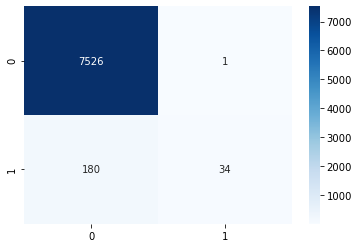

In [153]:
getMetricsData(y_test, y_pred)

In [128]:
# rf_defaults = {'n_jobs': -1,
#                'random_state': 100}

# space4nested = hp.pchoice('classifier_type',
#                           [(0.4, {
#                                   'min_samples_leaf': pyll.scope.int(pyll.scope.maximum(hp.qlognormal('min_samples_leaf', 2, 1.2, 1), 1)),
#                                   'max_features': hp.choice('max_features', [1.0, 0.5, 'sqrt', 'log2']),
#                                   'n_estimators':hp.choice('n_estimators',np.arange(100, 500+1,50, dtype=int)),
#                                   'max_depth':hp.uniform('max_depth',5,20),
#                                   'min_samples_split':hp.choice('min_samples_split',np.arange(2, 6+1,1, dtype=int))
                                  
#                                   }
#                             )]
#                           )

# def hyperopt_rfc_nested(params):
#     params = {**rf_defaults, **params}
#     rf_model = RandomForestClassifier(**params)
#     rf_model.fit(X_train_transformed, y_train)
#     return_dict = {'loss': -roc_auc_score(y_test, rf_model.predict_proba(X_test_transformed)[:, 1]),
#                    'status': STATUS_OK}
#     return return_dict

In [129]:
# trials = Trials()

# best = fmin(hyperopt_rfc_nested, space4nested, algo=tpe.suggest, max_evals=100, trials=trials)

# print(f'best: {space_eval(space4nested, best)}')

In [154]:
conn_object.close()